In [8]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
!pip install python-dotenv
import os
from dotenv import load_dotenv

env_path = '/content/drive/MyDrive/env/.env'
load_dotenv(env_path)

api_key = os.getenv('API_KEY')


In [1]:
!pip install nixtla utilsforecast
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [12]:
nixtla_client = NixtlaClient(
    api_key = api_key
)

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [14]:
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df, h=12, finetune_steps=10,
    time_col='timestamp', target_col='value',
)

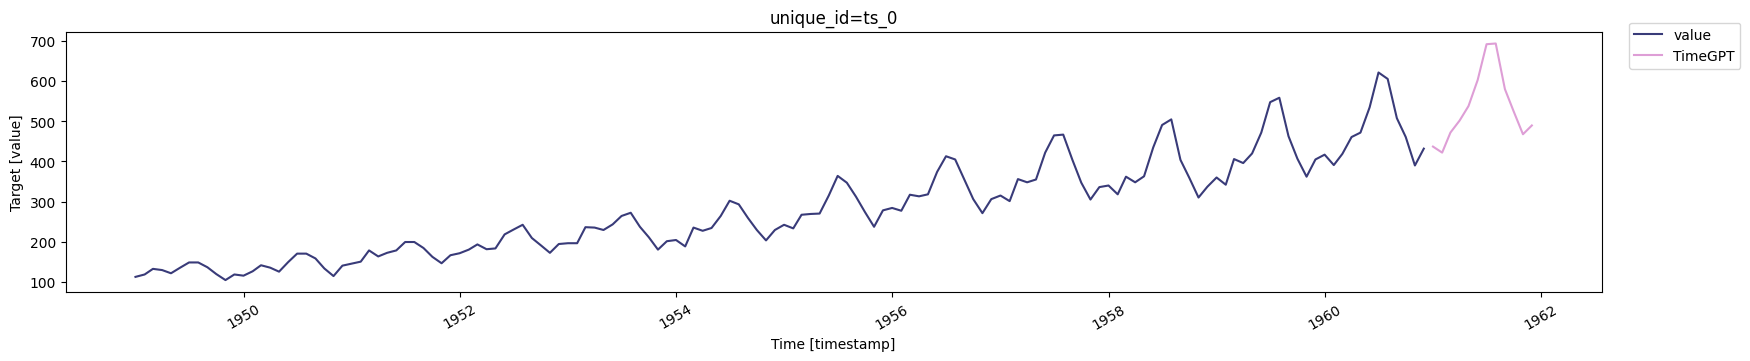

In [15]:
nixtla_client.plot(
    df, timegpt_fcst_finetune_df,
    time_col='timestamp', target_col='value',
)

In [16]:
train = df[:-24]
test = df[-24:]

depths = [1, 2, 3, 4, 5]

test = test.copy()

for depth in depths:
    preds_df = nixtla_client.forecast(
    df=train,
    h=24,
    finetune_steps=5,
    finetune_depth=depth,
    time_col='timestamp',
    target_col='value')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_depth{depth}'] = preds

In [17]:
test['unique_id'] = 0

evaluation = evaluate(test, metrics=[mae, mse], time_col="timestamp", target_col="value")
evaluation

,unique_id,metric,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5
0,0,mae,22.726334,17.908963,21.243560,24.745096,29.183245
1,0,mse,679.123472,461.320852,671.131971,991.835359,1147.905234
